# Mobility trends forecasting
## In this notebook we will implement a simple algorithm to forecast how mobility trends would have been if covid had not existed.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import requests
import itertools
import statsmodels.api as sm
from pylab import rcParams
from fbprophet import Prophet

## Let's star working with crime rates

In [3]:
municipal_crimes_df = pd.read_csv("Databases/Municipal-Delitos-2015-2020_oct2020.csv", encoding="latin_1")
#Rename months so we can sort them properly
municipal_crimes_df.columns = ['Año', 'Clave_Ent', 'Entidad', 'Cve. Municipio', 'Municipio',
       'Bien jurídico afectado', 'Tipo de delito', 'Subtipo de delito',
       'Modalidad', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [4]:
municipal_crimes_df.head()

,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,1,...,3,4,5,6,7,8,9,10,11,12
0,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,2,...,1,1,0,1,1,0,2,1,0.0,1.0
1,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma blanca,1,...,0,0,0,1,0,1,0,0,0.0,0.0
2,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con otro elemento,0,...,1,1,3,2,0,1,2,0,0.0,0.0
3,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,No especificado,1,...,0,1,0,0,0,0,0,0,0.0,0.0
4,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio culposo,Con arma de fuego,0,...,0,0,1,0,0,0,0,0,0.0,0.0


In [5]:
municipal_crimes_df = municipal_crimes_df.set_index(['Año', 'Clave_Ent', 'Entidad', 'Cve. Municipio', 'Municipio',
       'Bien jurídico afectado', 'Tipo de delito', 'Subtipo de delito',
       'Modalidad']).stack().reset_index().rename(columns={'level_9': 'Mes', 0: 'No. de delitos'})

In [6]:
municipal_crimes_df['Tipo de delito'].unique()

array(['Homicidio', 'Lesiones', 'Feminicidio', 'Aborto',
       'Otros delitos que atentan contra la vida y la integridad corporal',
       'Secuestro', 'Tráfico de menores', 'Rapto',
       'Otros delitos que atentan contra la libertad personal',
       'Abuso sexual', 'Acoso sexual', 'Hostigamiento sexual',
       'Violación simple', 'Violación equiparada', 'Incesto',
       'Otros delitos que atentan contra la libertad y la seguridad sexual',
       'Robo', 'Fraude', 'Abuso de confianza', 'Extorsión',
       'Daño a la propiedad', 'Despojo',
       'Otros delitos contra el patrimonio', 'Violencia familiar',
       'Violencia de género en todas sus modalidades distinta a la violencia familiar',
       'Incumplimiento de obligaciones de asistencia familiar',
       'Otros delitos contra la familia', 'Corrupción de menores',
       'Trata de personas', 'Otros delitos contra la sociedad',
       'Narcomenudeo', 'Amenazas', 'Allanamiento de morada',
       'Evasión de presos', 'Falsedad'

In [7]:
municipal_crimes_df['Subtipo de delito'].unique()

array(['Homicidio doloso', 'Homicidio culposo', 'Lesiones dolosas',
       'Lesiones culposas', 'Feminicidio', 'Aborto',
       'Otros delitos que atentan contra la vida y la integridad corporal',
       'Secuestro', 'Tráfico de menores', 'Rapto',
       'Otros delitos que atentan contra la libertad personal',
       'Abuso sexual', 'Acoso sexual', 'Hostigamiento sexual',
       'Violación simple', 'Violación equiparada', 'Incesto',
       'Otros delitos que atentan contra la libertad y la seguridad sexual',
       'Robo a casa habitación', 'Robo de vehículo automotor',
       'Robo de autopartes', 'Robo a transportista',
       'Robo a transeúnte en vía pública',
       'Robo a transeúnte en espacio abierto al público',
       'Robo en transporte público individual',
       'Robo en transporte público colectivo',
       'Robo en transporte individual', 'Robo a institución bancaria',
       'Robo a negocio', 'Robo de ganado', 'Robo de maquinaria',
       'Otros robos', 'Fraude', 'Abuso

## Como primera prueba realicemos el analisis a nivel nacional

In [8]:
national_crimes_df = municipal_crimes_df[['Año', 'Mes', 'No. de delitos']].groupby(['Año', 'Mes']).sum().reset_index()

national_crimes_df['DateTime'] = national_crimes_df.apply(lambda entry: pd.to_datetime(
    pd.Timestamp(year = int(entry['Año']), month = int(entry['Mes']), 
                 day = 1)), axis=1)

national_crimes_df.drop(columns = ['Año', 'Mes'], inplace=True)

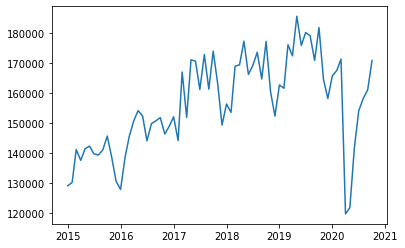

In [9]:
plt.plot(national_crimes_df.set_index('DateTime'))

## We need to split the dataframe in the data before and after COVID19
The pandemic started in mexico in march

In [10]:
national_crimes_before_covid_df = national_crimes_df.where(national_crimes_df['DateTime'] < pd.Timestamp(2020,3,23)).dropna().set_index('DateTime')
national_crimes_after_covid_df = national_crimes_df.where(national_crimes_df['DateTime'] > pd.Timestamp(2020,3,23)).dropna().set_index('DateTime')

In [11]:
national_crimes_after_covid_df.index

DatetimeIndex(['2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', name='DateTime', freq=None)

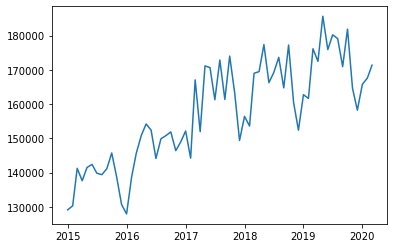

In [12]:
plt.plot(national_crimes_before_covid_df)

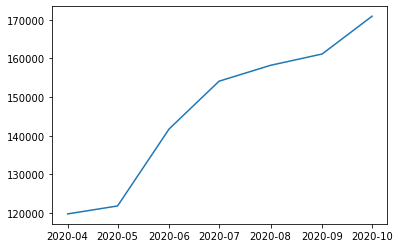

In [13]:
plt.plot(national_crimes_after_covid_df)

Let's see the decomposition of the national crimes taking covid into consideration.

There is a clear decline in the trend, this means that the pandemic had a strong impact in diminishing the total amount of crimes. 

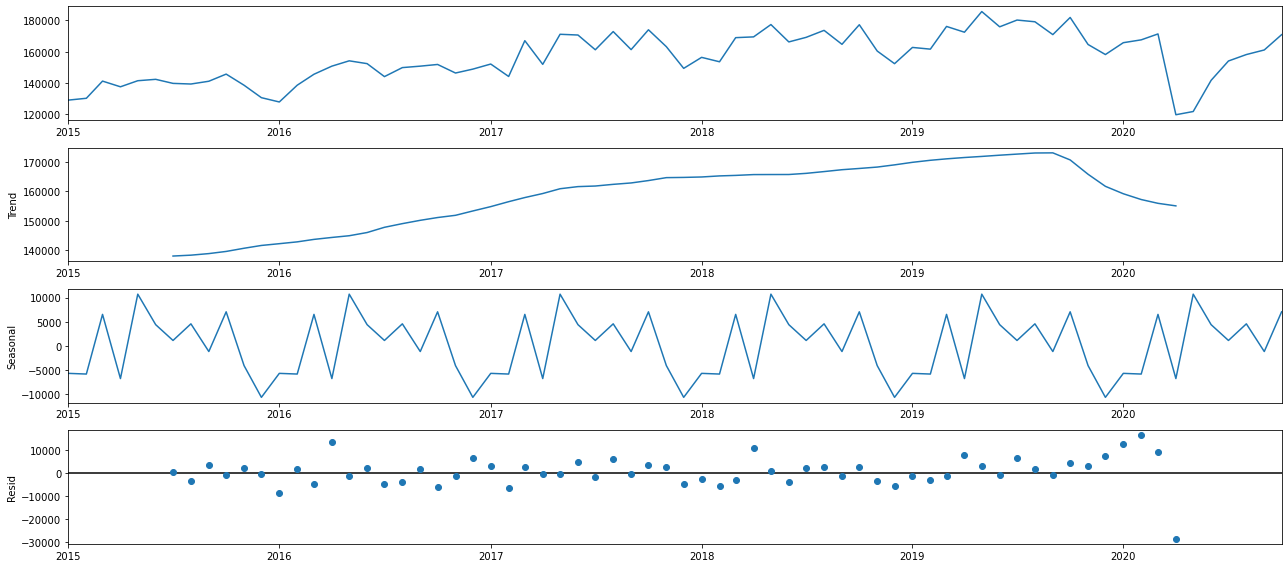

In [14]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(national_crimes_df.set_index('DateTime'), model='additive')
fig = decomposition.plot()
plt.show()

If we take into account only the crimes before covid, the trend is positive and considerably constant. We will make use of this data to predict how the trend would have been if the pandemic had not ocurred.

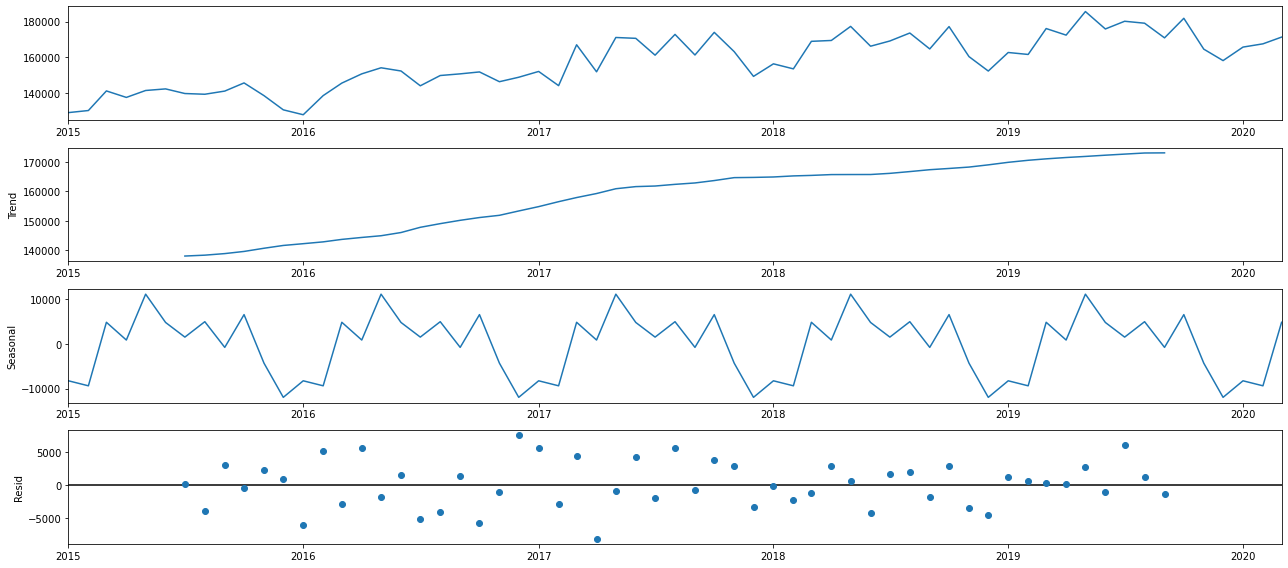

In [15]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(national_crimes_before_covid_df, model='additive')
fig = decomposition.plot()
plt.show()

## Let's use ARIMA as the time series forecaster

In [16]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [17]:
params_values = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(national_crimes_before_covid_df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False);
            results = mod.fit()
            params_values.append([param, param_seasonal, results.aic])
        except:
            continue

/home/ernesto/anaconda3/envs/EMTech/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/ernesto/anaconda3/envs/EMTech/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/ernesto/anaconda3/envs/EMTech/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/ernesto/anaconda3/envs/EMTech/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/ernesto/anaconda3/envs/EMT

In [18]:
pd.DataFrame(params_values).sort_values(2)

,0,1,2
31,"(0, 1, 1)","(1, 1, 1, 12)",735.454724
59,"(1, 1, 1)","(0, 1, 1, 12)",735.768205
27,"(0, 1, 1)","(0, 1, 1, 12)",743.230023
63,"(1, 1, 1)","(1, 1, 1, 12)",746.142114
62,"(1, 1, 1)","(1, 1, 0, 12)",750.702875
...,...,...,...
32,"(1, 0, 0)","(0, 0, 0, 12)",1308.256678
1,"(0, 0, 0)","(0, 0, 1, 12)",1315.207029
12,"(0, 0, 1)","(1, 0, 0, 12)",1321.904754
8,"(0, 0, 1)","(0, 0, 0, 12)",1594.960318


In [19]:
mod = sm.tsa.statespace.SARIMAX(national_crimes_before_covid_df,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5705      0.138     -4.127      0.000      -0.841      -0.300
ar.S.L12      -0.4183      0.480     -0.871      0.384      -1.359       0.523
ma.S.L12       0.0617      0.554      0.111      0.911      -1.025       1.148
sigma2      4.522e+07   1.77e-09   2.56e+16      0.000    4.52e+07    4.52e+07


/home/ernesto/anaconda3/envs/EMTech/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/ernesto/anaconda3/envs/EMTech/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


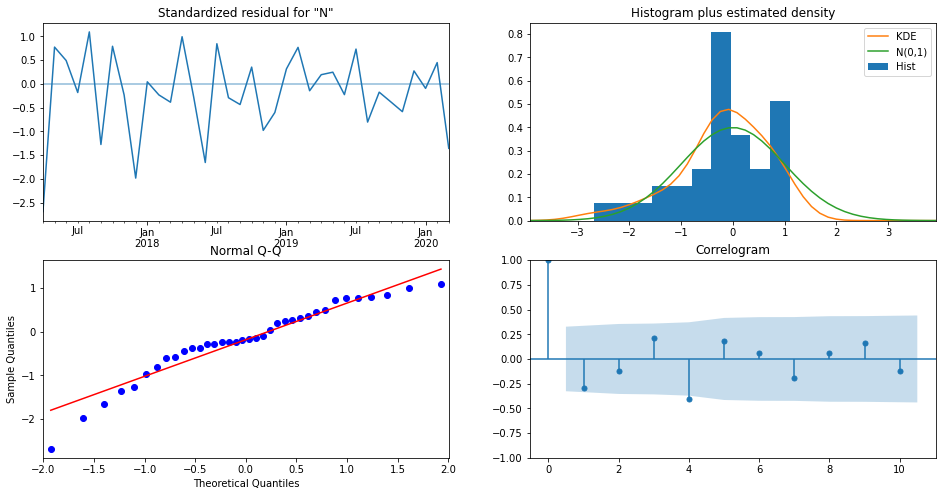

In [20]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [21]:
pred = results.get_prediction(start=pd.to_datetime('2020-03-01'), end=pd.to_datetime('2020-10-01'), dynamic=False)
pred_ci = pred.conf_int()

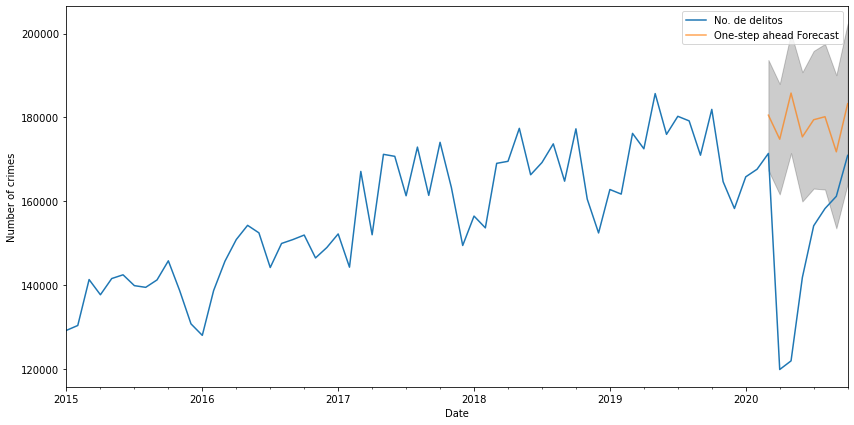

In [22]:
ax = national_crimes_df.set_index('DateTime').plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Number of crimes')
plt.legend()
plt.show()

## Let's use FBProphet to predict this data

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


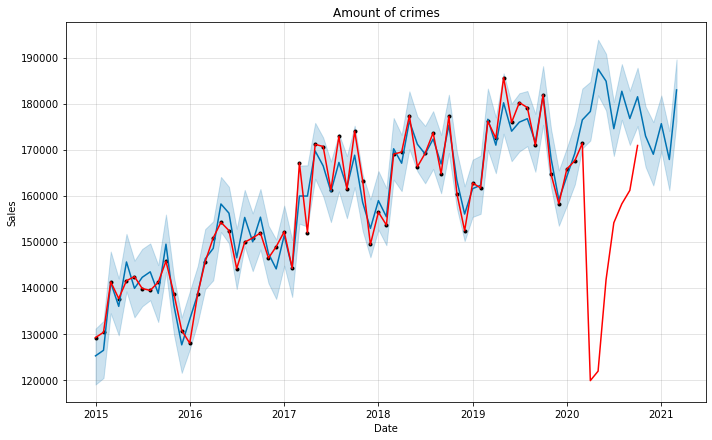

In [24]:
nat_crimes_before_cov_df_renamed = national_crimes_before_covid_df.reset_index().rename(
    columns={'DateTime': 'ds', 'No. de delitos': 'y'})
national_crimes_model = Prophet(interval_width=0.95)
national_crimes_model.fit(nat_crimes_before_cov_df_renamed)

national_crimes_forecast = national_crimes_model.make_future_dataframe(periods=12, freq='MS')
national_crimes_forecast = national_crimes_model.predict(national_crimes_forecast)

national_crimes_model.plot(national_crimes_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.plot(national_crimes_df.set_index('DateTime'), color='r')
plt.title('Amount of crimes');

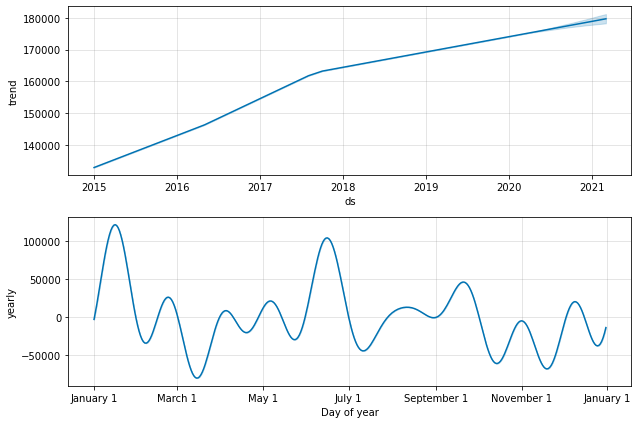

In [25]:
fig2 = national_crimes_model.plot_components(national_crimes_forecast)

## Let's repeat all over again, but splitting in gender and sexual crimes vs robbery and see the trends

In [26]:
sex_and_gender_crimes = ['Homicidio doloso', 'Aborto',  'Feminicidio', 'Aborto',
       'Otros delitos que atentan contra la vida y la integridad corporal',
       'Secuestro', 'Tráfico de menores', 'Rapto',
       'Otros delitos que atentan contra la libertad personal',
       'Abuso sexual', 'Acoso sexual', 'Hostigamiento sexual',
       'Violación simple', 'Violación equiparada', 'Incesto',
       'Otros delitos que atentan contra la libertad y la seguridad sexual', 
        'Violencia familiar',
       'Violencia de género en todas sus modalidades distinta a la violencia familiar',
       'Otros delitos contra la familia', 'Corrupción de menores',
       'Trata de personas']

In [27]:
robbery_crimes = ['Robo a casa habitación', 'Robo de vehículo automotor',
       'Robo de autopartes', 'Robo a transportista',
       'Robo a transeúnte en vía pública',
       'Robo a transeúnte en espacio abierto al público',
       'Robo en transporte público individual',
       'Robo en transporte público colectivo',
       'Robo en transporte individual', 'Robo a institución bancaria',
       'Robo a negocio', 'Robo de ganado', 'Robo de maquinaria',
       'Otros robos', 'Fraude', 'Abuso de confianza', 'Extorsión', 'Despojo', 'Allanamiento de morada']

In [28]:
municipal_sex_gender_crimes_df = municipal_crimes_df.where(municipal_crimes_df['Subtipo de delito'].isin(sex_and_gender_crimes)).dropna()

In [29]:
municipal_robbery_crimes_df = municipal_crimes_df.where(municipal_crimes_df['Subtipo de delito'].isin(robbery_crimes)).dropna()

In [30]:
national_sex_gender_crimes_df = municipal_sex_gender_crimes_df[['Año', 'Mes', 'No. de delitos']].groupby(['Año', 'Mes']).sum().reset_index()

national_sex_gender_crimes_df['DateTime'] = national_sex_gender_crimes_df.apply(lambda entry: pd.to_datetime(
    pd.Timestamp(year = int(entry['Año']), month = int(entry['Mes']), 
                 day = 1)), axis=1)

national_sex_gender_crimes_df.drop(columns = ['Año', 'Mes'], inplace=True)

In [31]:
national_robbery_df = municipal_robbery_crimes_df[['Año', 'Mes', 'No. de delitos']].groupby(['Año', 'Mes']).sum().reset_index()

national_robbery_df['DateTime'] = national_robbery_df.apply(lambda entry: pd.to_datetime(
    pd.Timestamp(year = int(entry['Año']), month = int(entry['Mes']), 
                 day = 1)), axis=1)

national_robbery_df.drop(columns = ['Año', 'Mes'], inplace=True)

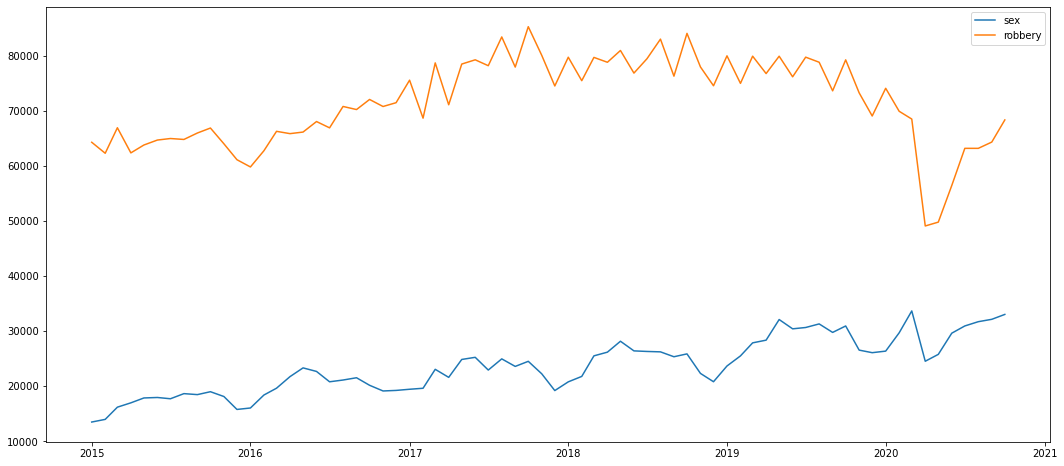

In [34]:
plt.plot(national_sex_gender_crimes_df.set_index('DateTime'), label='sex')
plt.plot(national_robbery_df.set_index('DateTime'), label = 'robbery')
plt.legend()

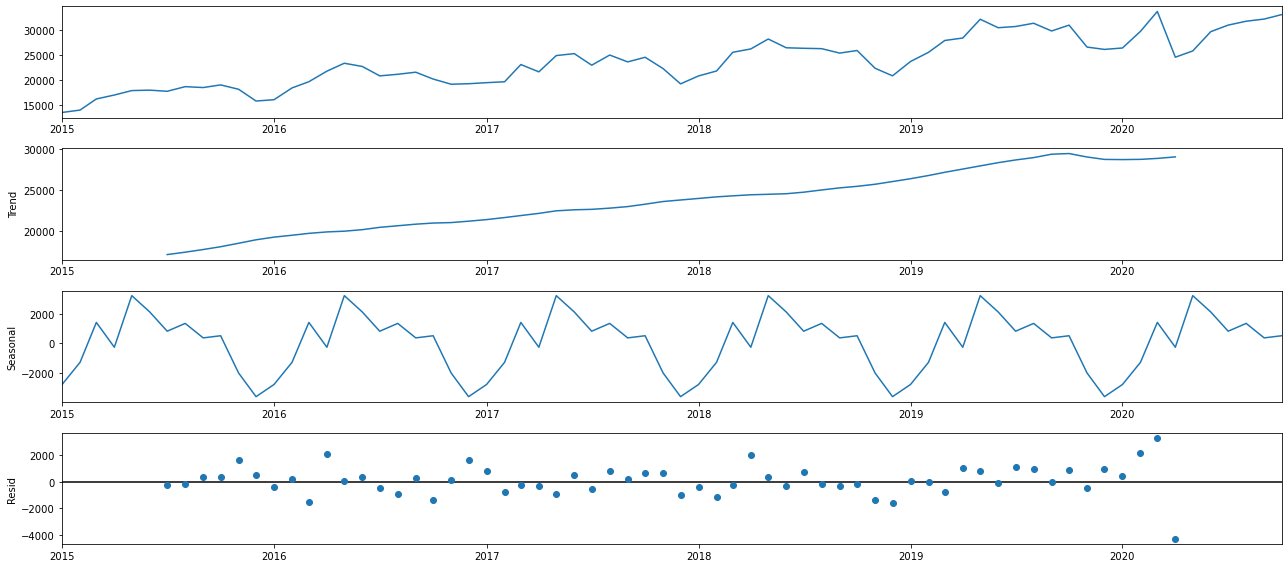

In [35]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(national_sex_gender_crimes_df.set_index('DateTime'), model='additive')
fig = decomposition.plot()
plt.show()

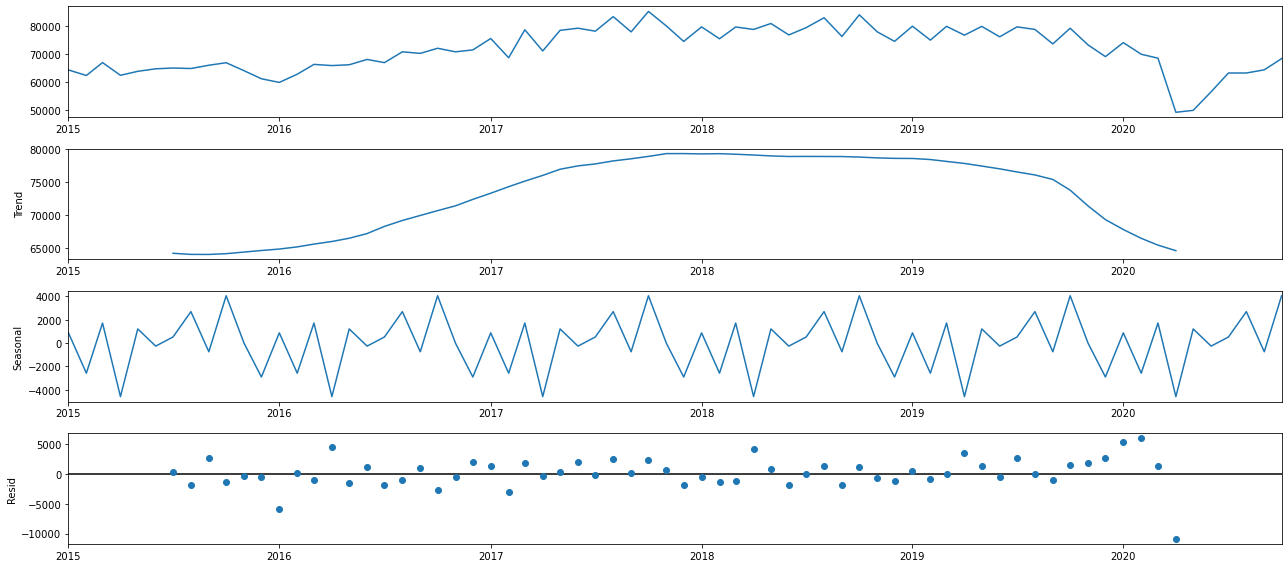

In [36]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(national_robbery_df.set_index('DateTime'), model='additive')
fig = decomposition.plot()
plt.show()

## Let's split both dataframes in before and after covid19

In [37]:
national_sex_gender_crimes_before_covid_df = national_sex_gender_crimes_df.where(
    national_sex_gender_crimes_df['DateTime'] < pd.Timestamp(2020,3,23)).dropna().set_index('DateTime')

national_sex_gender_crimes_after_covid_df = national_sex_gender_crimes_df.where(
    national_sex_gender_crimes_df['DateTime'] > pd.Timestamp(2020,3,23)).dropna().set_index('DateTime')

In [38]:
national_robbery_crimes_before_covid_df = national_robbery_df.where(
    national_robbery_df['DateTime'] < pd.Timestamp(2020,3,23)).dropna().set_index('DateTime')

national_robbery_crimes_after_covid_df = national_robbery_df.where(
    national_robbery_df['DateTime'] > pd.Timestamp(2020,3,23)).dropna().set_index('DateTime')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


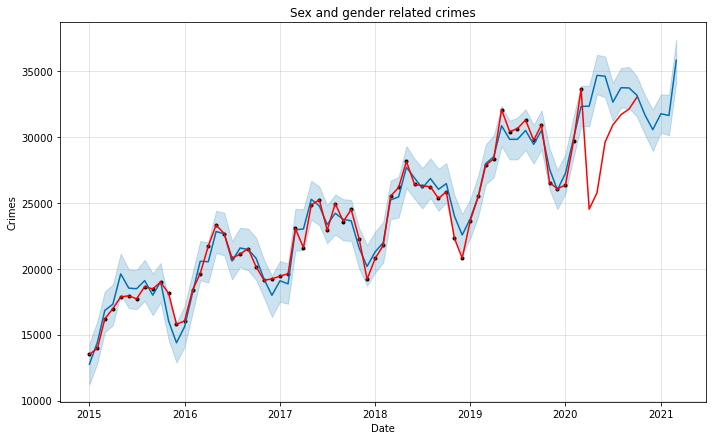

In [47]:
nat_sg_crimes_before_cov_df_renamed = national_sex_gender_crimes_before_covid_df.reset_index().rename(
    columns={'DateTime': 'ds', 'No. de delitos': 'y'})
national_sg_crimes_model = Prophet(interval_width=0.95)
national_sg_crimes_model.fit(nat_sg_crimes_before_cov_df_renamed)

national_sg_crimes_forecast = national_sg_crimes_model.make_future_dataframe(periods=12, freq='MS')
national_sg_crimes_forecast = national_sg_crimes_model.predict(national_sg_crimes_forecast)

national_sg_crimes_model.plot(national_sg_crimes_forecast, xlabel = 'Date', ylabel = 'Crimes')
plt.plot(national_sex_gender_crimes_df.set_index('DateTime'), color='r')
plt.title('Sex and gender related crimes');

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


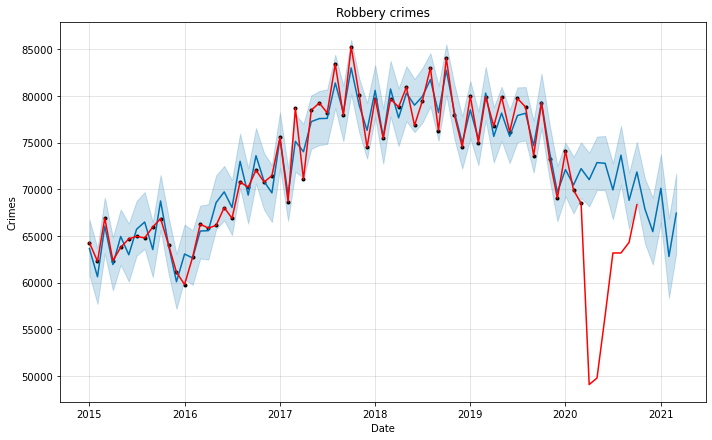

In [46]:
nat_robbery_crimes_before_cov_df_renamed = national_robbery_crimes_before_covid_df.reset_index().rename(
    columns={'DateTime': 'ds', 'No. de delitos': 'y'})
national_robbery_crimes_model = Prophet(interval_width=0.95)
national_robbery_crimes_model.fit(nat_robbery_crimes_before_cov_df_renamed)

national_robbery_crimes_forecast = national_robbery_crimes_model.make_future_dataframe(periods=12, freq='MS')
national_robbery_crimes_forecast = national_robbery_crimes_model.predict(national_robbery_crimes_forecast)

national_robbery_crimes_model.plot(national_robbery_crimes_forecast, xlabel = 'Date', ylabel = 'Crimes')
plt.plot(national_robbery_df.set_index('DateTime'), color='r')
plt.title('Robbery crimes');